In [1]:
from gensim.test.utils import datapath
from gensim.models import Word2Vec
from gensim.models.word2vec import Text8Corpus, LineSentence
import pandas as pd
import spacy
import unidecode
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import numpy as np
import matplotlib 
import seaborn as sns

In [7]:
w2vmodel = Word2Vec.load("models/word2vec_sg.model")

In [8]:
len(w2vmodel.wv.index_to_key)

144965

In [10]:
topic_terms = pd.read_csv("models/top_terms_hdp.csv",
                         sep = ";", 
                         encoding = "utf-8",
                         quotechar = "\"") 

In [11]:
topic_terms

,term
0,dictadura
1,venezuela
2,chile
3,gente
4,piñera
5,gobierno


In [21]:
def construct_tsne(keys, wmodel, topnw = 20):
    embedding_clusters = []
    word_clusters = []
    for word in keys:
        embeddings = []
        words = []
        for similar_word, _ in wmodel.wv.most_similar(word, topn=topnw):
            words.append(similar_word)
            embeddings.append(wmodel.wv[similar_word])
        embedding_clusters.append(embeddings)
        word_clusters.append(words)

    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
    embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
    return embeddings_en_2d, word_clusters

In [22]:
from adjustText import adjust_text
from matplotlib.colors import rgb2hex
import matplotlib.patches as mpatches

In [39]:
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None, fsize = (16,9), emo_marker = [], word_anot = True):
    fig = plt.figure(figsize=fsize, dpi = 144)
    ax = fig.add_subplot(111)
    p = []
    colors = []
    colors.append(list(map(rgb2hex, sns.color_palette('Oranges', n_colors=len(labels))))[1])
    colors.append(list(map(rgb2hex, sns.color_palette('Purples', n_colors=len(labels))))[1])
    #sns.palplot(cluster_colors[1])
    #sns.palplot(cluster_colors[2])
    #colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    if len(emo_marker) == 0:
        emo_marker = [0]*len(labels)
    #colors = color.reshape(1,-1)
    for label, embeddings, words, color, marker in zip(labels, embedding_clusters, word_clusters, colors, emo_marker):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        ax.scatter(x, y, alpha=a, label=label, s = 40, color = color)
        #plt.scatter(x, y, c=color, alpha=a, label=label)
        if(word_anot):
            for i, word in enumerate(words):
                p.append(ax.annotate(word, xy = (x[i], y[i]), size = 8))
                #texts = plt.text(x[i], y[i], word)

               # plt.annotate(word, alpha=0.8, xy=(x[i], y[i]), xytext=(5, 2),
                            #textcoords='offset points', ha='right', va='bottom', size=6)
    against_clus = mpatches.Patch(color=colors[0], label='against')
    favor_clus = mpatches.Patch(color=colors[1], label='in favor')
    plt.legend(handles = [against_clus, favor_clus], loc='upper right', prop={'size': 8})
    adjust_text(p)
    plt.title(title, fontsize = 10)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    #plt.grid(True)
    if filename:
        #plt.savefig(filename)
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight', pad_inches=0.0)
    ax.grid(False)

    plt.show()

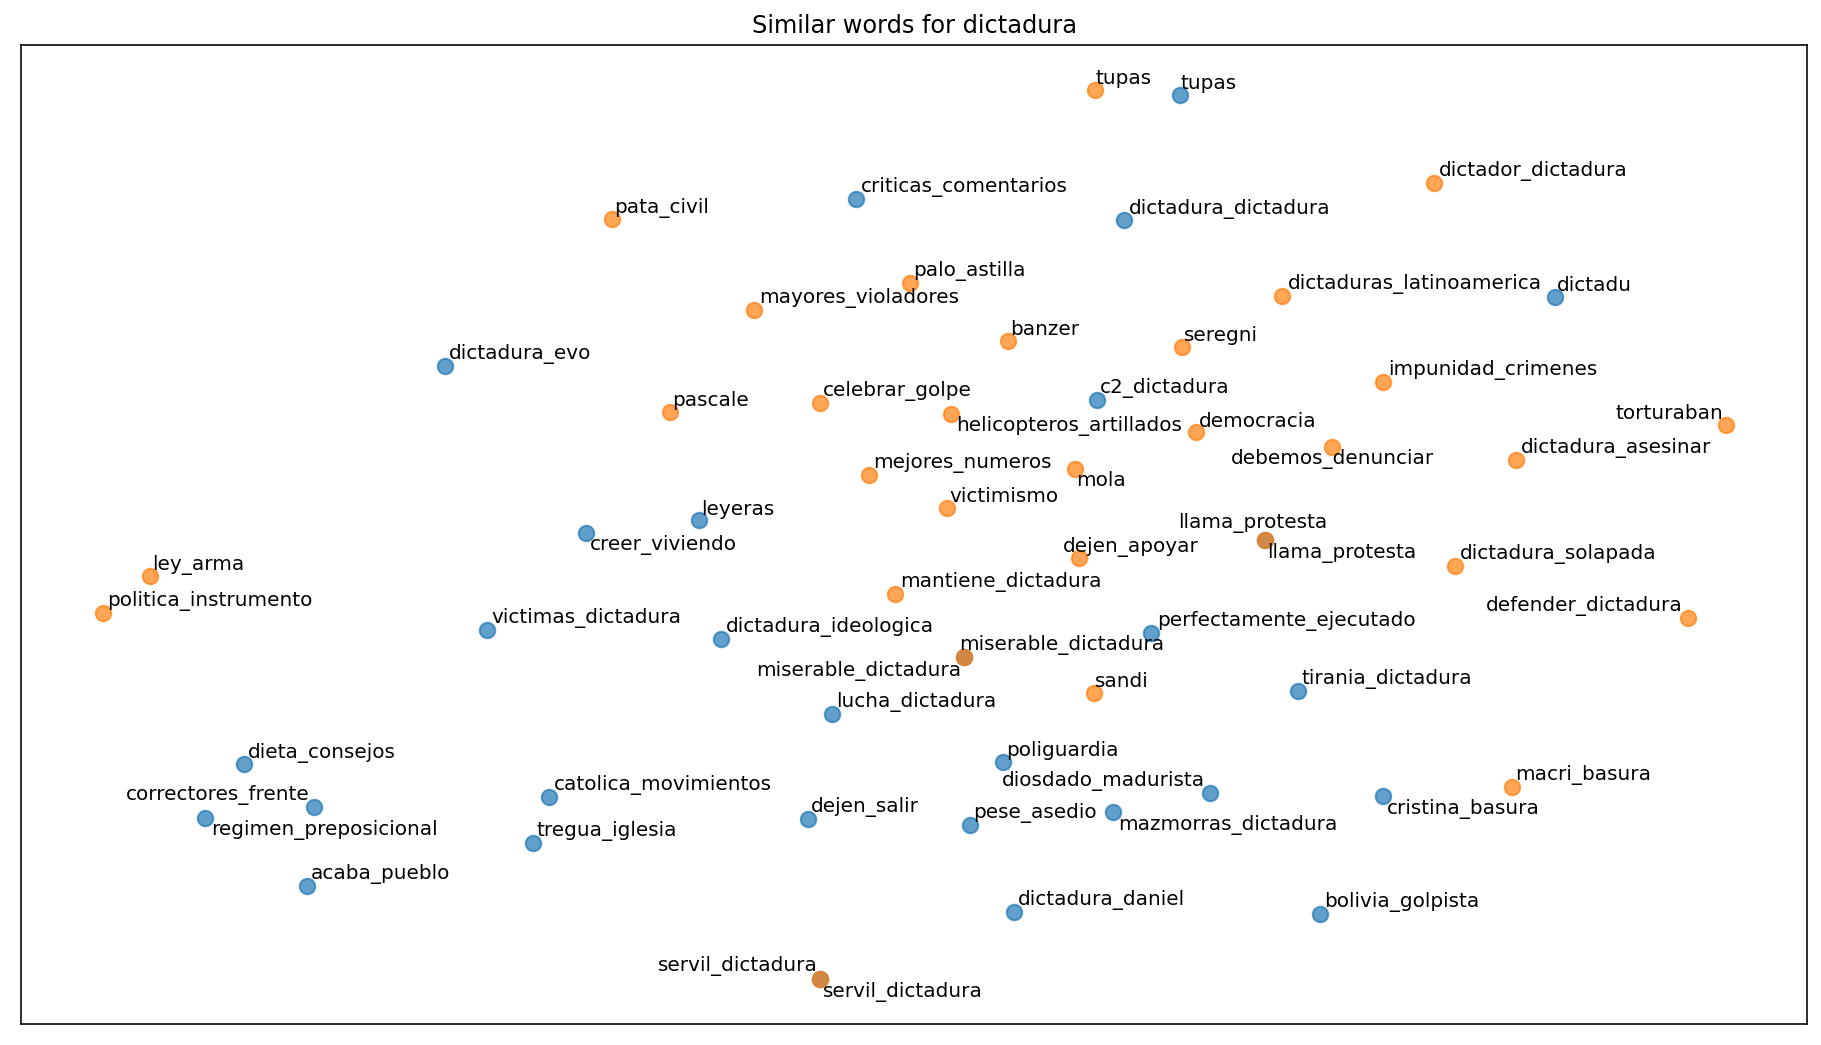

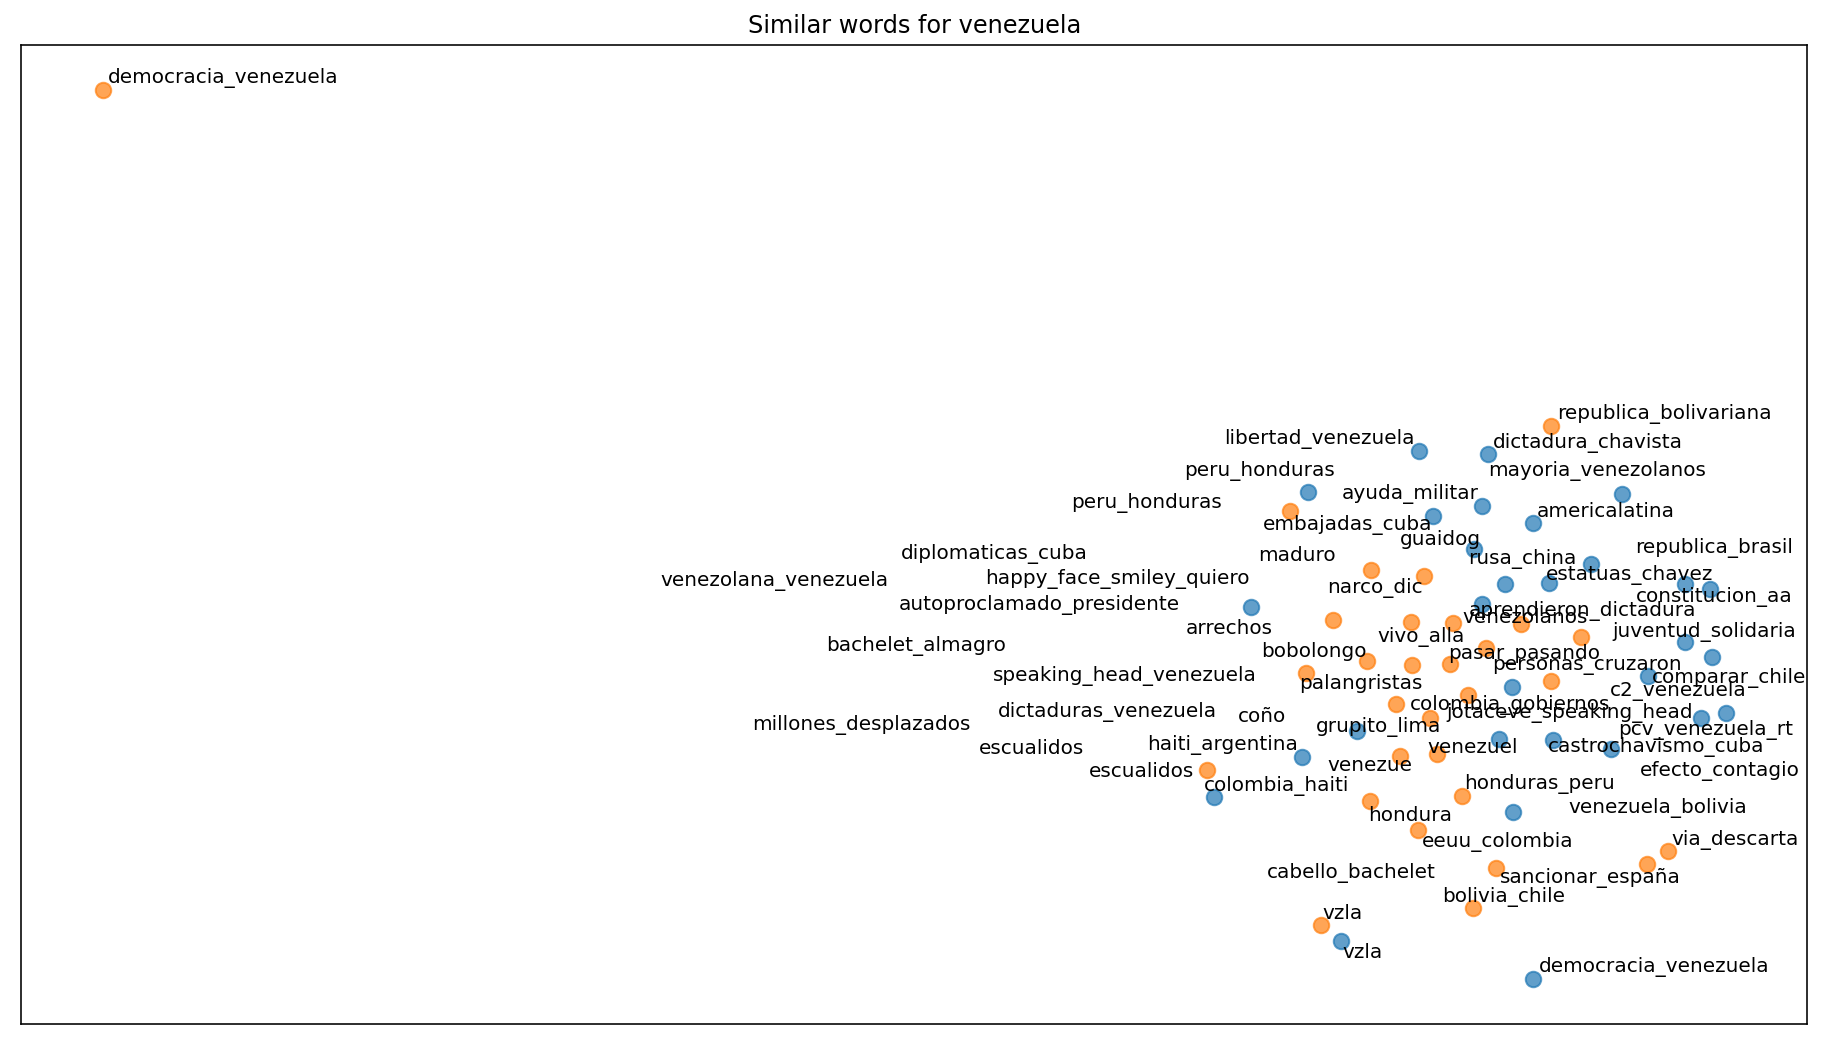

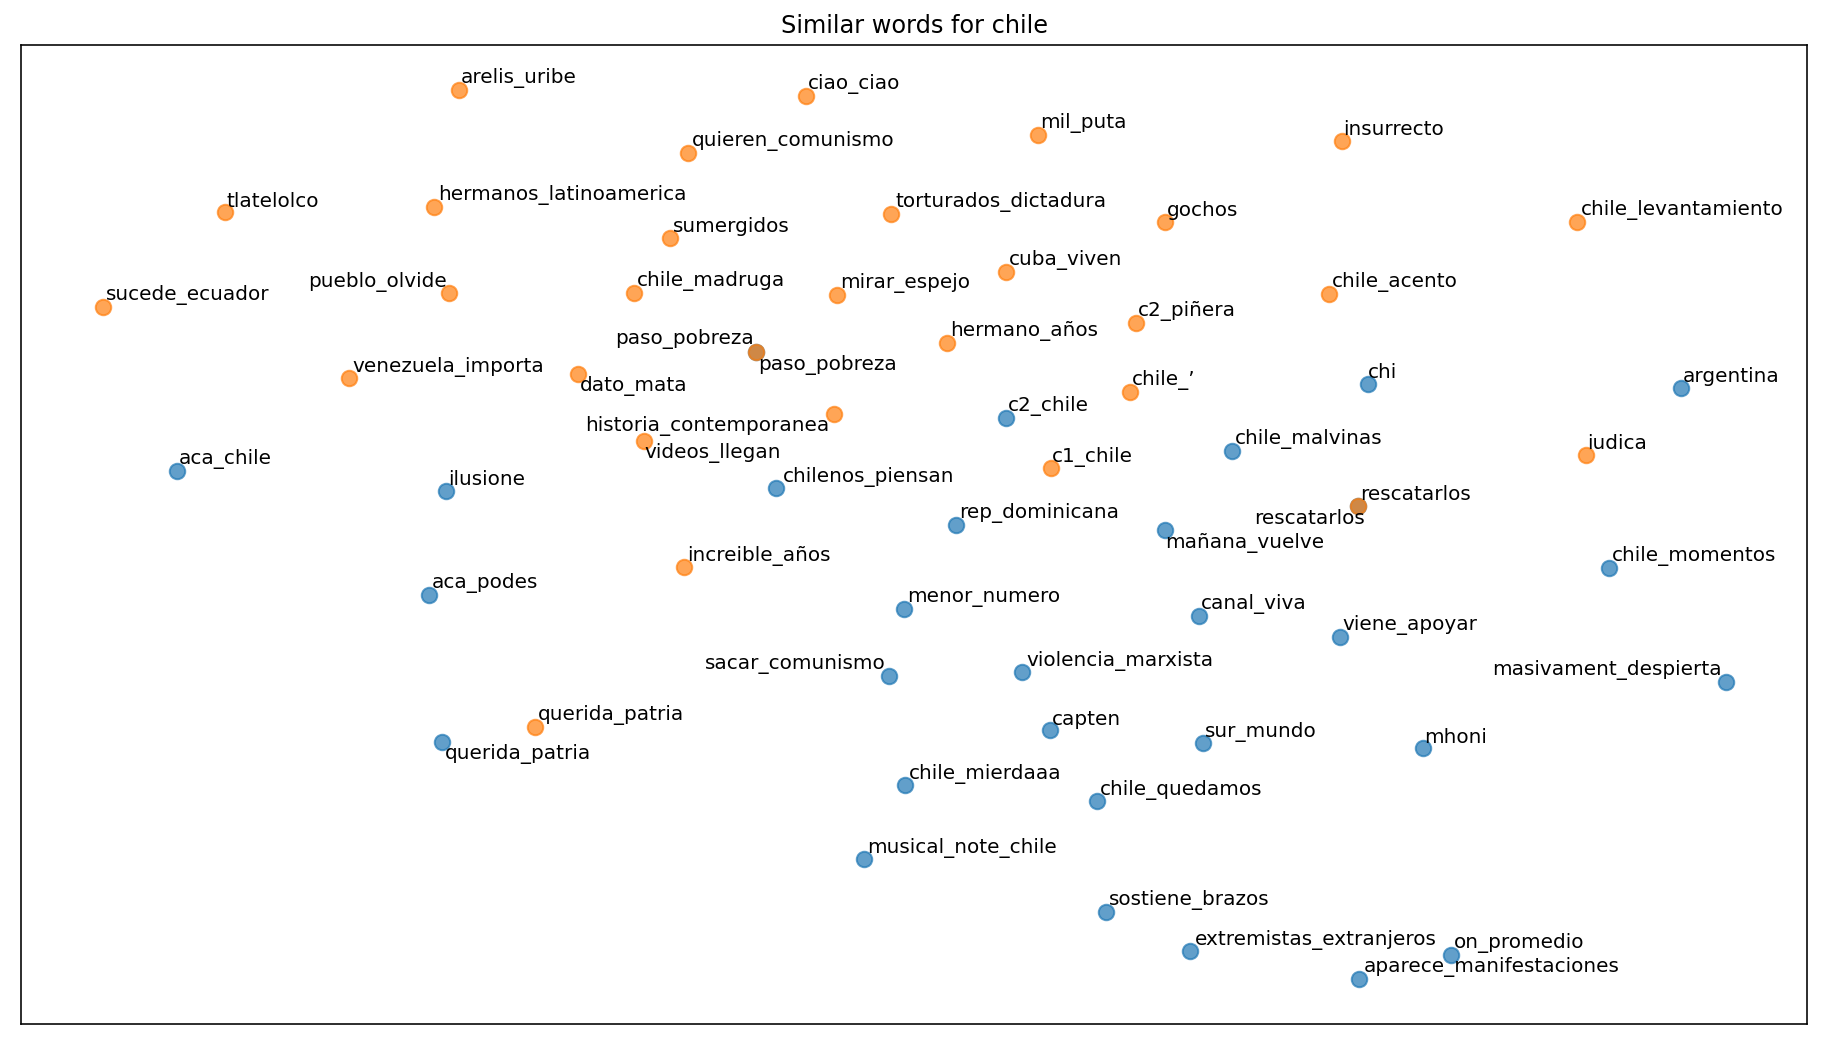

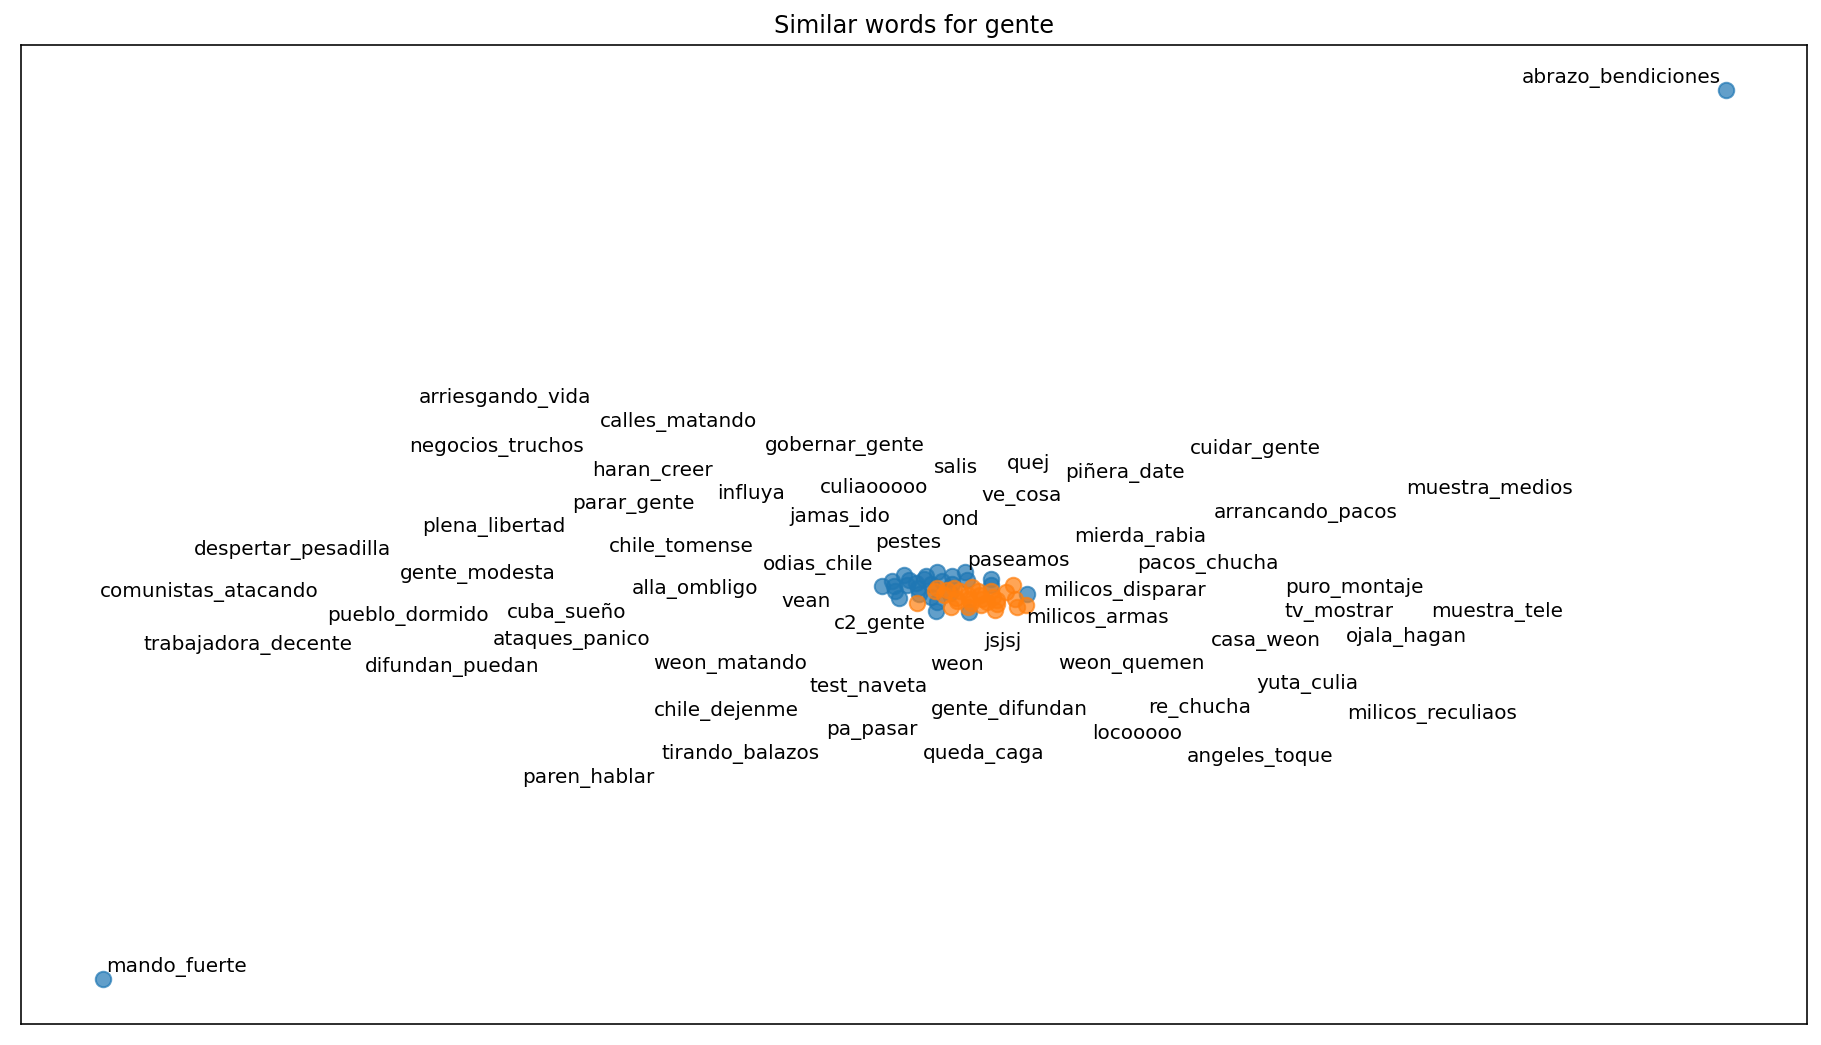

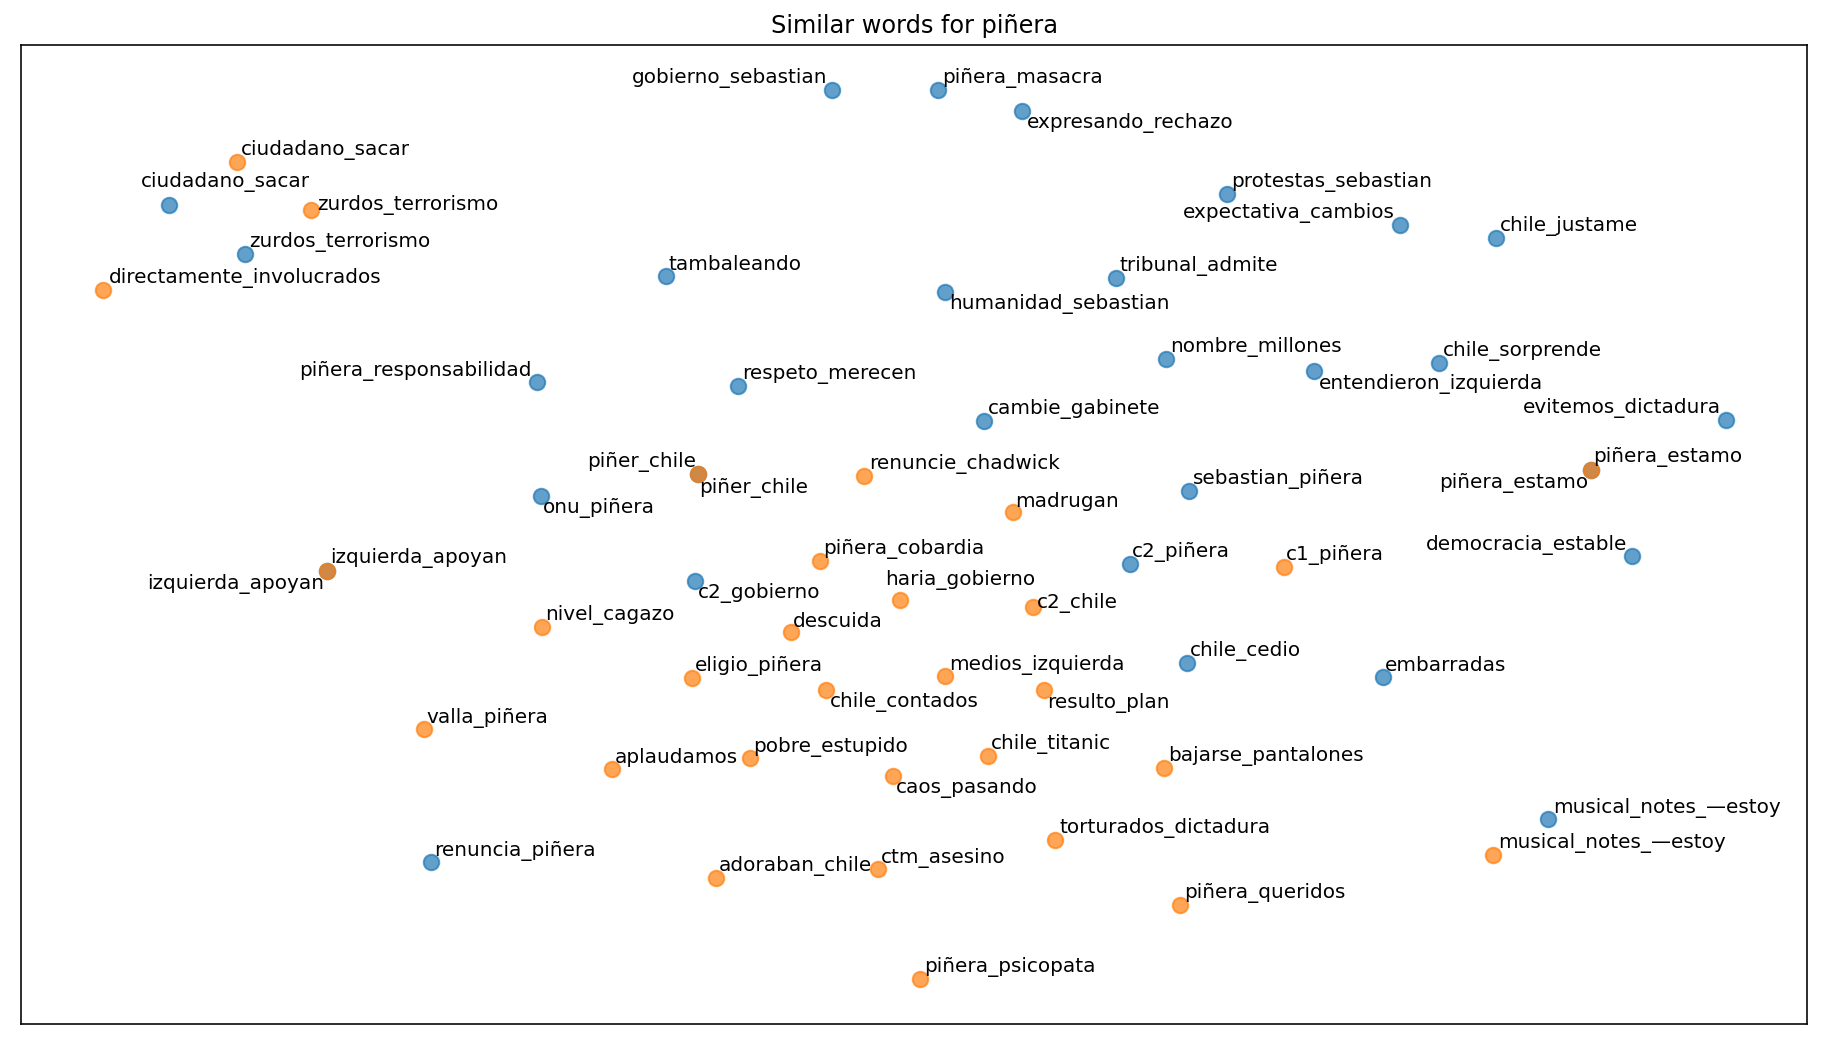

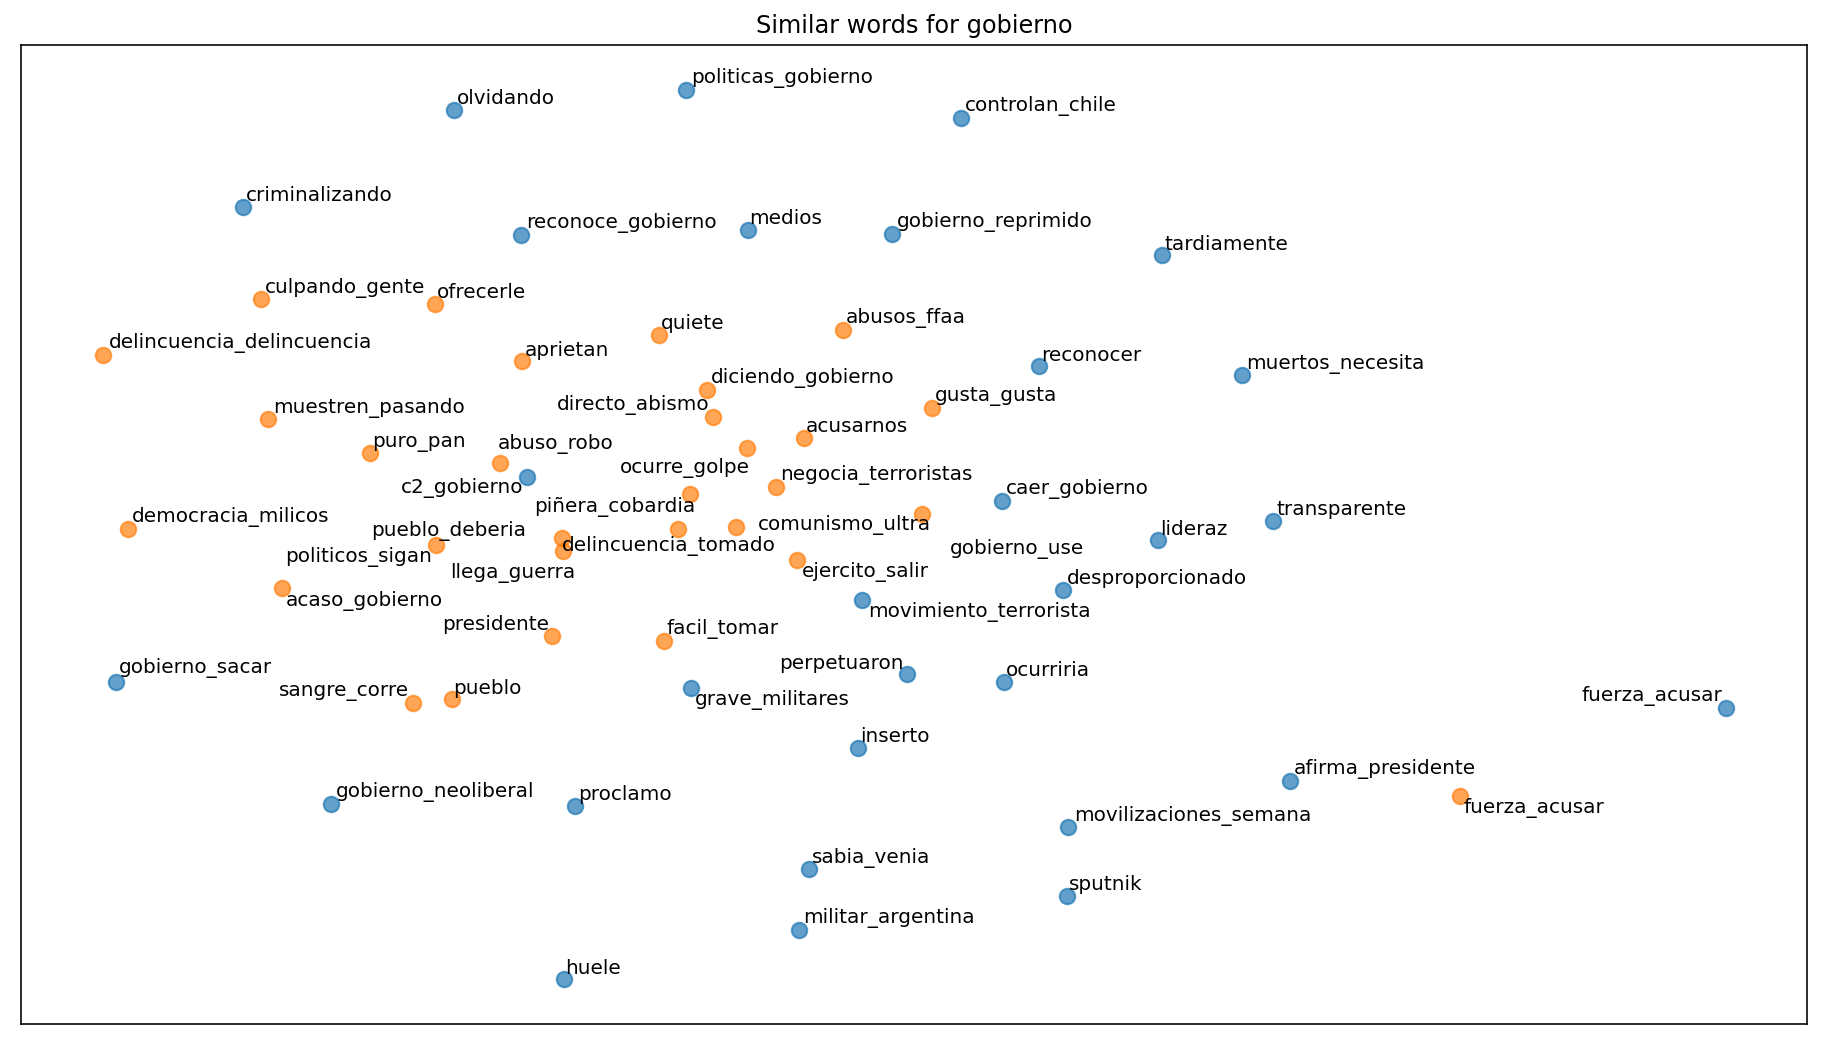

In [27]:
for index, row in topic_terms.iterrows():
    if 'c1_'+row['term'] in w2vmodel.wv and 'c2_'+row['term'] in w2vmodel.wv:
        keys = ['c1_'+ row['term'], 'c2_'+ row['term']]
        tsne_build = construct_tsne(keys, w2vmodel, 30)
        tsne_plot_similar_words('Similar words for '+row['term'], keys, tsne_build[0], tsne_build[1], 0.7)